# 04 — Stock Clustering

Applies K-Means and Gaussian Mixture Model clustering on PCA-reduced features.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.clustering import StockClusterer

sns.set_style('whitegrid')
pd.set_option('display.max_columns', 100)
%matplotlib inline

## 1. Load Data

In [2]:
pca_data = pd.read_parquet("../data/processed/pca_data.parquet")
feature_matrix = pd.read_parquet("../data/processed/feature_matrix.parquet")
fundamentals_df = pd.read_parquet("../data/raw/fundamentals.parquet")

if 'sector' in fundamentals_df.columns:
    sectors = fundamentals_df.loc[pca_data.index, 'sector'].fillna("Unknown")
else:
    sectors = pd.Series("Unknown", index=pca_data.index)

print(f"PCA data: {pca_data.shape}")
print(f"Feature matrix: {feature_matrix.shape}")

PCA data: (30, 7)
Feature matrix: (30, 38)


## 2. K-Means Clustering

Optimal K-Means k = 6 (silhouette = 0.318)


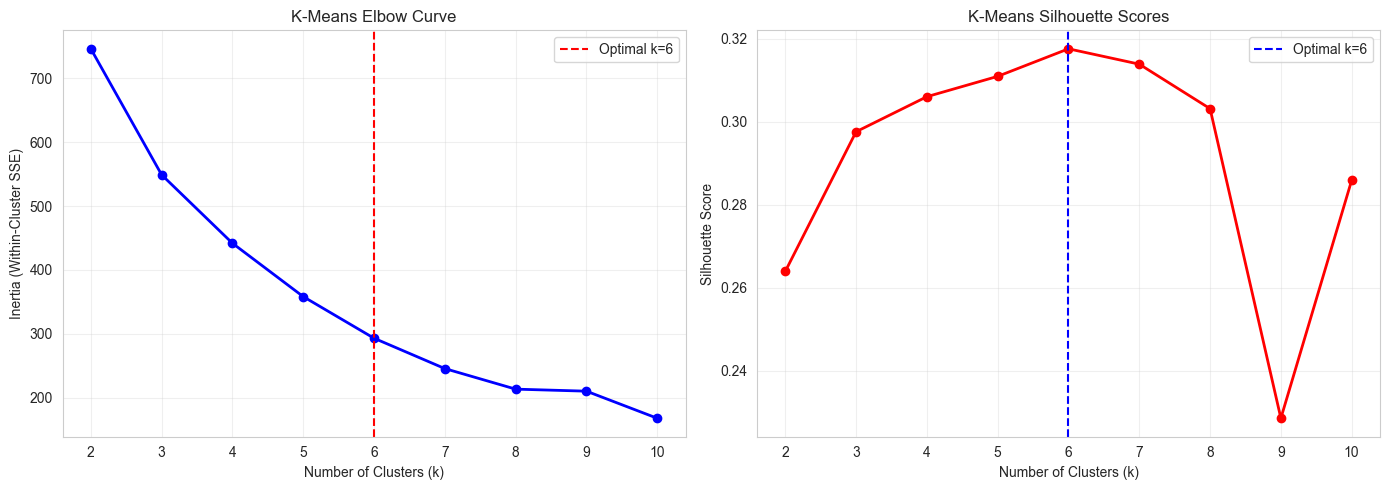

K-Means evaluation complete


In [3]:
clusterer = StockClusterer(max_clusters=10)
kmeans_metrics = clusterer.evaluate_kmeans(pca_data)
clusterer.plot_elbow_and_silhouette(save=True)
print("K-Means evaluation complete")

## 3. Fit Optimal K-Means

In [4]:
kmeans_labels = clusterer.fit_kmeans(pca_data)
print(f"Cluster distribution:\n{kmeans_labels.value_counts().sort_index()}")

Cluster distribution:
0    11
1     6
2     2
3     2
4     1
5     8
Name: KMeans_Cluster, dtype: int64


## 4. Visualize K-Means Clusters

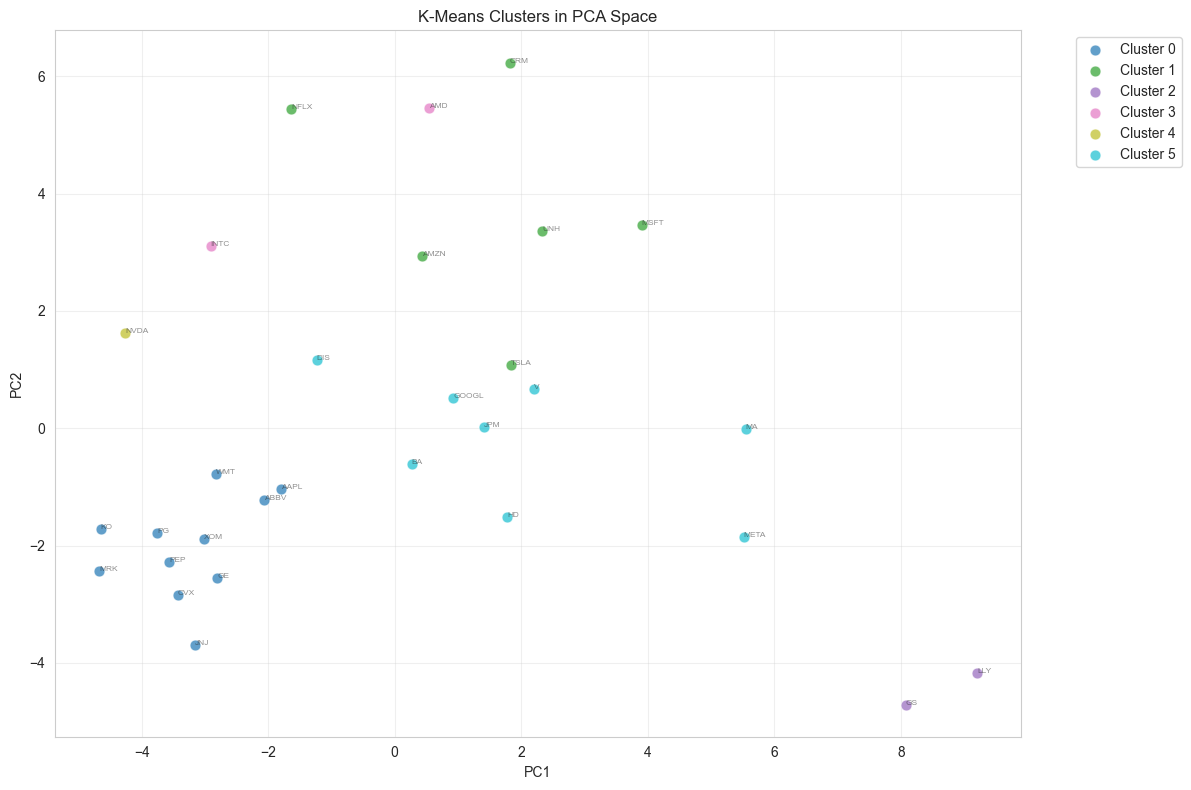

In [5]:
clusterer.plot_cluster_scatter(pca_data, kmeans_labels, title="K-Means Clusters in PCA Space", save=True)

## 5. Cluster Composition

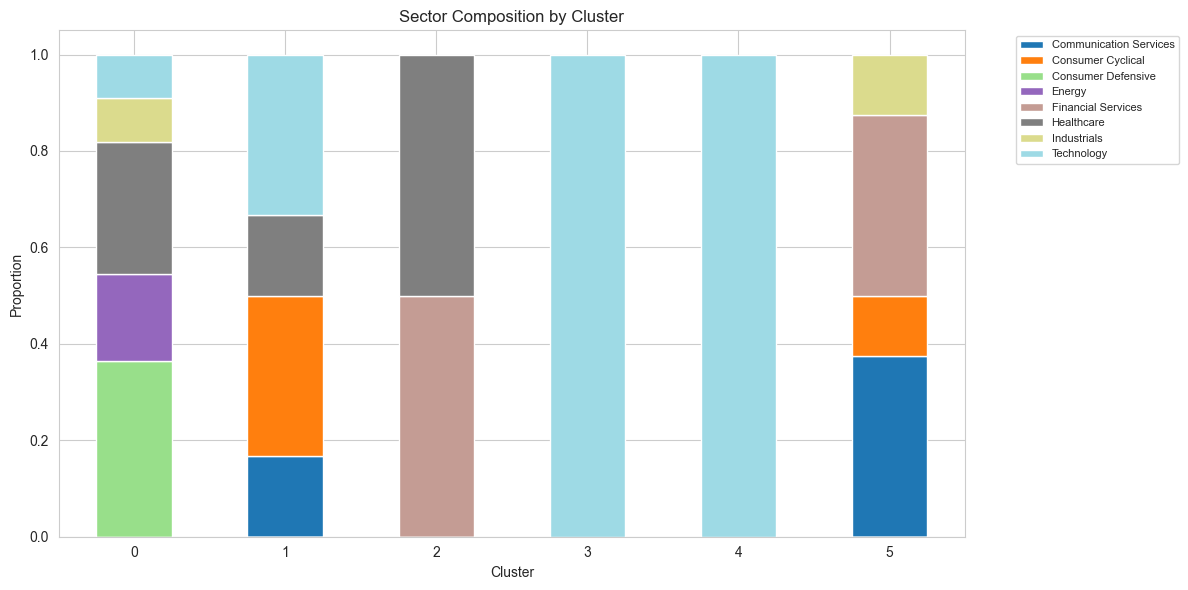

         count         Dominant_Sector  Sector_Concentration  \
Cluster                                                        
0           11      Consumer Defensive              0.363636   
1            6       Consumer Cyclical              0.333333   
2            2      Financial Services              0.500000   
3            2              Technology              1.000000   
4            1              Technology              1.000000   
5            8  Communication Services              0.375000   

                                                  Tickers  
Cluster                                                    
0        AAPL, JNJ, MRK, ABBV, XOM, CVX, PG, KO, PEP, WMT  
1                        MSFT, AMZN, TSLA, UNH, CRM, NFLX  
2                                                 GS, LLY  
3                                               AMD, INTC  
4                                                    NVDA  
5                    GOOGL, META, JPM, V, MA, HD, DIS, BA  


In [6]:
clusterer.plot_cluster_composition(kmeans_labels, sectors, save=True)
cluster_summary = clusterer.get_cluster_summary(kmeans_labels, feature_matrix, sectors)
print(cluster_summary)

## 6. Gaussian Mixture Model Clustering

Optimal GMM k = 9 (BIC = 160.2)


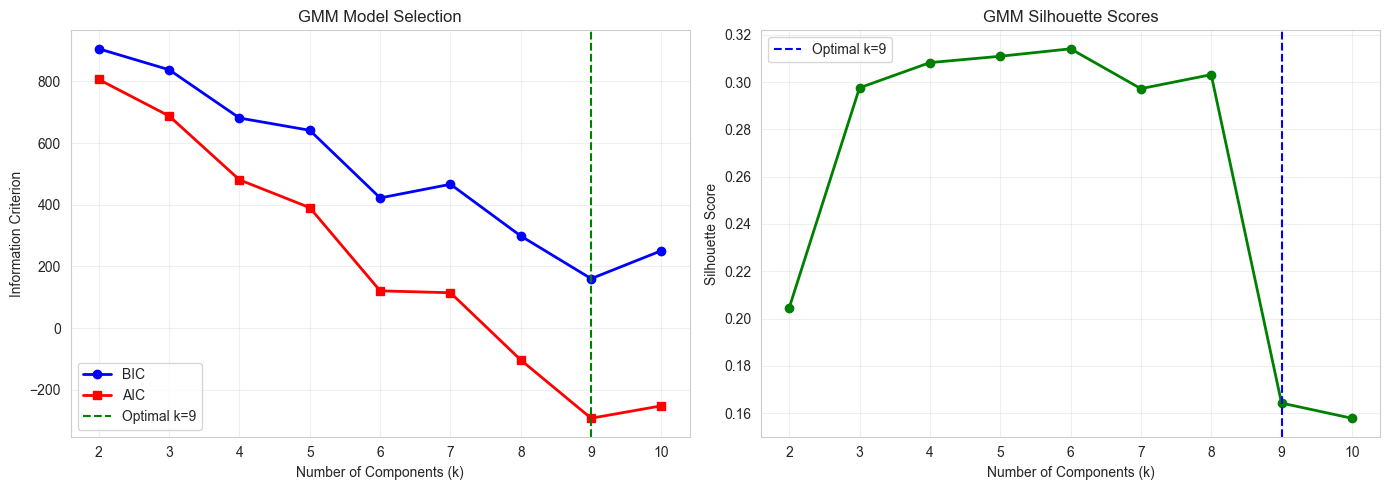

GMM evaluation complete


In [7]:
gmm_metrics = clusterer.evaluate_gmm(pca_data)
clusterer.plot_gmm_evaluation(save=True)
print("GMM evaluation complete")

## 7. Fit GMM

GMM cluster distribution:
0    4
1    1
2    3
3    5
4    4
5    3
6    1
7    2
8    7
Name: GMM_Cluster, dtype: int64


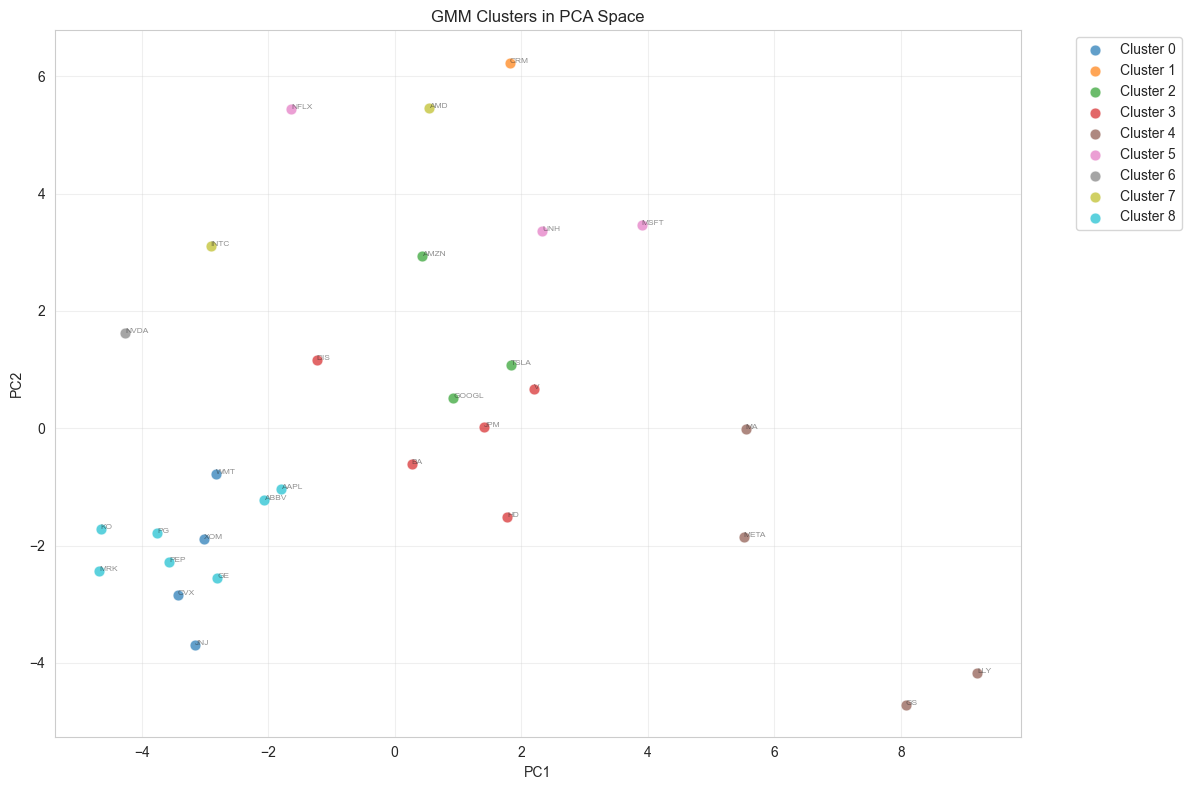

In [8]:
gmm_labels, gmm_probs = clusterer.fit_gmm(pca_data)
print(f"GMM cluster distribution:\n{gmm_labels.value_counts().sort_index()}")
clusterer.plot_cluster_scatter(pca_data, gmm_labels, title="GMM Clusters in PCA Space", save=True, filename="gmm_cluster_scatter.png")

## 8. Compare K-Means vs GMM

In [9]:
comparison = pd.DataFrame({"KMeans": kmeans_labels, "GMM": gmm_labels})
print("Cross-tabulation of K-Means vs GMM:")
print(pd.crosstab(comparison["KMeans"], comparison["GMM"]))

Cross-tabulation of K-Means vs GMM:
GMM     0  1  2  3  4  5  6  7  8
KMeans                           
0       4  0  0  0  0  0  0  0  7
1       0  1  2  0  0  3  0  0  0
2       0  0  0  0  2  0  0  0  0
3       0  0  0  0  0  0  0  2  0
4       0  0  0  0  0  0  1  0  0
5       0  0  1  5  2  0  0  0  0


## 9. Save Results

In [10]:
cluster_results = pd.DataFrame({"kmeans_cluster": kmeans_labels, "gmm_cluster": gmm_labels}, index=pca_data.index)
cluster_results.to_parquet("../data/processed/cluster_labels.parquet")
print(f"Saved cluster labels: {cluster_results.shape}")

Saved cluster labels: (30, 2)
